## Predicting number of victims in collisions in California

Game plan:
- Consider data from June 3, 2020 - June 3, 2021

In [1]:
# basics
import pandas as pd
import numpy as np
import shap
import sqlite3

# initial stab at the problem
from sklearn.model_selection import train_test_split

# displaying
np.set_printoptions(threshold=80)
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)

In [2]:
con = sqlite3.connect('../../../iCloud/Employment/Plentina/switrs.sqlite')

query_injured = """
SELECT c.injured_victims, 
       c.case_id, 
       c.collision_date, 
       c.collision_time,        
       c.alcohol_involved, 
       SUBSTR(c.county_city_location, -4, 2) AS county_code, 
       c.lighting,
       c.road_surface, 
       c.road_condition_1, 
       c.weather_1,
       c.intersection, 
       c.state_highway_indicator,
       p.party_age,
       p.cellphone_use_type,
       p.party_drug_physical
FROM `collisions` AS c
LEFT JOIN `parties` AS p
ON c.case_id = p.case_id
WHERE c.collision_date IS NOT NULL 
AND c.collision_time IS NOT NULL
AND c.chp_beat_type IS NOT 'interstate'
AND p.party_type IS 'driver'
AND p.at_fault = 1
AND date(c.collision_date) BETWEEN date('2020-06-03') and date('2021-06-03')
"""

df_injuredMain = pd.read_sql_query(query_injured, con, parse_dates=['collision_date'])


In [3]:
df_injured = df_injuredMain.copy()


In [4]:
df_injured.isna().sum()

injured_victims                 0
case_id                         0
collision_date                  0
collision_time                  0
alcohol_involved           222527
county_code                     0
lighting                      731
road_surface                 2601
road_condition_1             1260
weather_1                     984
intersection                 1460
state_highway_indicator      1591
party_age                   53723
cellphone_use_type          36213
party_drug_physical        187881
dtype: int64

In [5]:
# df_injured['weather_1'] = df_injured['weather_1'].fillna('-1')
# df_injured['lighting'] = df_injured['lighting'].fillna(-1)
# df_injured['road_surface'] = df_injured['road_surface'].fillna(-1)
# df_injured['road_condition_1'] = df_injured['road_condition_1'].fillna(-1)

df_injured['alcohol_involved'] = df_injured['alcohol_involved'].fillna(0).astype(int)
df_injured['intersection'] = df_injured['intersection'].fillna(0).astype(int)
df_injured['state_highway_indicator'] = df_injured['state_highway_indicator'].fillna(
    0).astype(int)

missingCategorical = ['lighting', 'road_surface', 'road_condition_1', 'weather_1',
'cellphone_use_type', 'party_drug_physical']
for var in missingCategorical:
    df_injured[var] = df_injured[var].fillna('-1')

df_injured['party_age'] = df_injured['party_age'].fillna(-1)


In [6]:
df_injured.isna().sum()


injured_victims            0
case_id                    0
collision_date             0
collision_time             0
alcohol_involved           0
county_code                0
lighting                   0
road_surface               0
road_condition_1           0
weather_1                  0
intersection               0
state_highway_indicator    0
party_age                  0
cellphone_use_type         0
party_drug_physical        0
dtype: int64

In [7]:
display(df_injured['weather_1'].value_counts())
display(df_injured['lighting'].value_counts())
display(df_injured['road_surface'].value_counts())
display(df_injured['road_condition_1'].value_counts())

clear      230776
cloudy      17574
raining      4017
fog          1123
-1            984
other         559
snowing       246
wind          136
Name: weather_1, dtype: int64

daylight                                   157787
dark with street lights                     63123
dark with no street lights                  23411
dusk or dawn                                 9875
-1                                            731
dark with street lights not functioning       487
G                                               1
Name: lighting, dtype: int64

dry         240882
wet          10937
-1            2601
snowy          789
slippery       148
H               56
I                1
J                1
Name: road_surface, dtype: int64

normal            246990
construction        4635
-1                  1260
other                674
holes                646
obstruction          564
loose material       306
reduced width        241
flooded               99
Name: road_condition_1, dtype: int64

In [8]:
df_injuredCleaned = df_injured.loc[(df_injured['lighting'] != 'G') &
    (df_injured['road_surface'] != 'H') &
    (df_injured['road_surface'] != 'I') &
    (df_injured['road_surface'] != 'J') &
    (df_injured['cellphone_use_type'] != '4')].reset_index(drop=True)


In [9]:
df_injuredCleaned['collision_hour'] = pd.to_datetime(
    df_injuredCleaned['collision_time'], format='%H:%M:%S').dt.hour.astype(str)
df_injuredCleaned['collision_day_of_week'] = pd.to_datetime(
    df_injuredCleaned['collision_date']).dt.dayofweek.astype(str)
df_injuredCleaned['collision_month'] = pd.to_datetime(
    df_injuredCleaned['collision_date']).dt.month.astype(str)

In [10]:
df_injuredCleaned

,injured_victims,case_id,collision_date,collision_time,alcohol_involved,county_code,lighting,road_surface,road_condition_1,weather_1,intersection,state_highway_indicator,party_age,cellphone_use_type,party_drug_physical,collision_hour,collision_day_of_week,collision_month
0,0,0726202,2020-07-26,02:50:00,0,36,dark with street lights,dry,normal,clear,0,0,-1.0,-1,G,2,6,7
1,0,77779235,2021-02-24,23:56:00,1,19,dark with street lights,dry,normal,clear,0,0,53.0,no cellphone/unknown,-1,23,2,2
2,0,8008483,2020-10-05,22:36:00,1,56,dark with street lights,wet,normal,clear,0,0,27.0,cellphone not in use,-1,22,0,10
3,2,8008484,2020-08-06,21:25:00,0,19,dark with street lights,dry,normal,clear,0,0,61.0,cellphone not in use,-1,21,3,8
4,0,8008487,2020-10-05,15:11:00,0,56,daylight,dry,normal,clear,0,0,41.0,cellphone not in use,-1,15,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254272,0,9143681,2020-08-06,06:13:00,1,42,daylight,dry,normal,clear,0,1,20.0,cellphone not in use,-1,6,3,8
254273,0,9158913,2020-08-22,11:03:00,0,33,daylight,dry,normal,clear,1,1,19.0,-1,G,11,5,8
254274,0,9160890,2020-08-23,04:10:00,1,30,dark with street lights,dry,normal,clear,0,0,62.0,cellphone not in use,-1,4,6,8
254275,0,9162606,2020-08-02,19:53:00,0,50,daylight,dry,normal,clear,0,0,44.0,-1,G,19,6,8


In [11]:
# SELECT case_id, latitude, longitude, collision_date, SUBSTR(county_city_location, -4, 2) AS county_code,
# collision_time, collision_severity,
# severe_injury_count, other_visible_injury_count,
# complaint_of_pain_injury_count, pedestrian_killed_count,
# pedestrian_injured_count, bicyclist_killed_count,
# bicyclist_injured_count, motorcyclist_killed_count,
# motorcyclist_injured_count, killed_victims, injured_victims,
# party_count, primary_collision_factor, pcf_violation_code,
# pcf_violation_category, pcf_violation, pcf_violation_subsection,
# pedestrian_collision, bicycle_collision, motorcycle_collision, truck_collision,
# hit_and_run


In [12]:
df_dummies = pd.get_dummies(df_injuredCleaned[['county_code', 'lighting', 'road_surface',
                            'road_condition_1', 'weather_1', 'collision_hour', 'collision_day_of_week', 
                            'cellphone_use_type','party_drug_physical']])


In [13]:
dataset = pd.concat([df_dummies, df_injuredCleaned[[
                    'alcohol_involved', 'intersection', 'state_highway_indicator', 'party_age', 'injured_victims']]], axis=1)


In [14]:
X = dataset.iloc[:, :133]
y = dataset['injured_victims']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=875)



In [15]:
display(y.value_counts())

print("Number of cases with injured victims:")
display(y.value_counts()[1:].sum())


0     151903
1      71547
2      21519
3       6358
4       1937
5        645
6        227
7         80
8         30
9         22
10         5
16         1
15         1
13         1
12         1
Name: injured_victims, dtype: int64

Number of cases with injured victims:


102374

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

lr_rmodel = LinearRegression().fit(X_train, y_train)
mae_lr = mean_absolute_error(y_test, lr_rmodel.predict(X_test))
print('Linear Regression Mean Absolute Error is:', mae_lr)


Linear Regression Mean Absolute Error is: 0.6220406043830105


In [17]:
X_trees = df_injuredCleaned.iloc[:, 4:]
y_trees = df_injuredCleaned['injured_victims']

X_trees[['county_code', 'lighting', 'road_surface',
         'road_condition_1', 'weather_1', 'collision_hour', 'collision_day_of_week',
         'cellphone_use_type', 'party_drug_physical']] = X_trees[['county_code', 'lighting', 'road_surface',
         'road_condition_1', 'weather_1', 'collision_hour', 'collision_day_of_week',
         'cellphone_use_type', 'party_drug_physical']].astype("category")

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_trees, y_trees, test_size=.3, random_state=875)


In [18]:
dt_model = DecisionTreeRegressor(random_state=875).fit(X_train, y_train)
mae_dt = mean_absolute_error(y_test2, dt_model.predict(X_test))
print('Decision Tree Regressor Mean Absolute Error is:', mae_dt)

ValueError: could not convert string to float: 'daylight'

In [26]:
rf_rmodel = RandomForestRegressor(random_state=875).fit(X_train, y_train)
rf_mae = mean_absolute_error(y_test, rf_rmodel.predict(X_test))
print('Random Forest Regressor Mean Absolute Error is:', rf_mae)

Random Forest Regressor Mean Absolute Error is: 0.638861698253566


In [22]:
ab_rmodel = AdaBoostRegressor(random_state=875).fit(X_train, y_train)
ab_mae = mean_absolute_error(y_test, ab_rmodel.predict(X_test))
print('AdaBoost Regressor Mean Squared Error is:', ab_mae)

AdaBoost Regressor Mean Squared Error is: 1.6207790666283506


In [25]:
gbm_rmodel1 = GradientBoostingRegressor(random_state=875).fit(X_train, y_train)
gbm_mae = mean_absolute_error(y_test, gbm_rmodel1.predict(X_test))
print('Gradient Boosting Regressor Mean Squared Error is:', gbm_mae)


Gradient Boosting Regressor Mean Squared Error is: 0.6192942031139946


In [92]:
pd.DataFrame({'Model':['Linear Regression', 'Decision Tree', 'Random Forest Regressor', 'AdaBoost Regressor', 'Gradient Boosting Regressor'],
              'MAE': [mae_lr, mae_dt, rf_mae, ab_mae, gbm_mae]})


,Model,MAE
0,Linear Regression,0.646510
1,Decision Tree,0.672545
2,Random Forest Regressor,0.656356
3,AdaBoost Regressor,0.732334
4,Gradient Boosting Regressor,0.717860


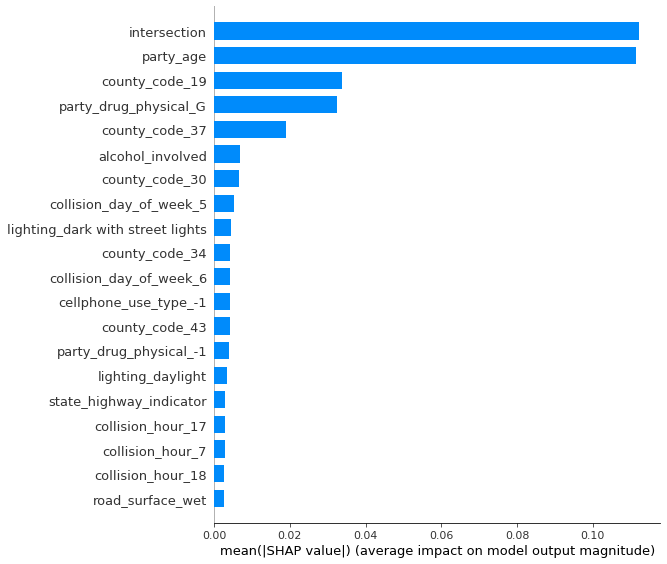

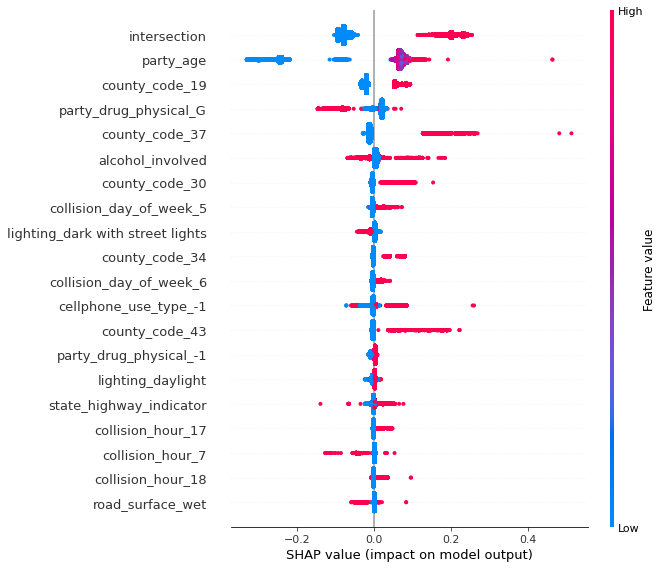

In [27]:
features = list(X.columns)

explainer = shap.TreeExplainer(gbm_rmodel1)

shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train,
                  feature_names=features, plot_type="bar")
shap.summary_plot(shap_values, X_train, feature_names=features)


In [28]:
#i = 'intersection'
shap.initjs()
shap.force_plot(explainer.expected_value[0],
                shap_values[25], X_test.iloc[25], feature_names=features)


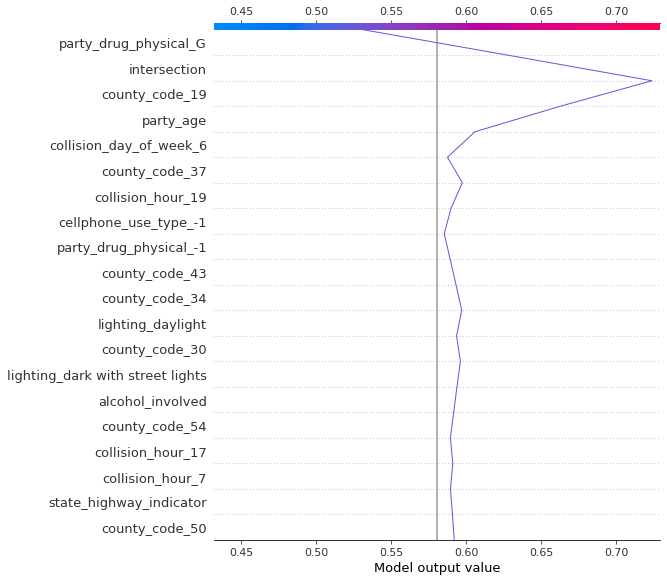

In [29]:
shap.decision_plot(
    explainer.expected_value[0], shap_values[0], feature_names=list(features))


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


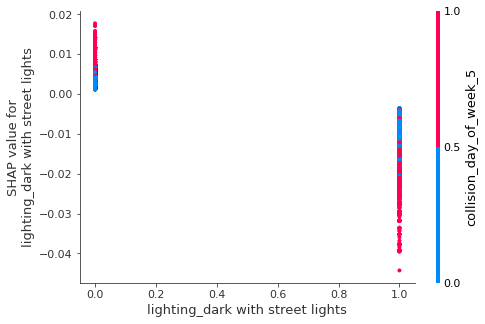

In [30]:
shap.dependence_plot("lighting_dark with street lights", shap_values, X_train, feature_names=features)


In [ ]:
shap.dependence_plot("intersection", shap_values,
                     X_train, feature_names=features)
